# Solutions for chapter 6 exercises (WORK IN PROGRESS - UNFINISHED)

## Set up

In [30]:
# Common libraries
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import seaborn as sns

# Chapter-specific libraries
from statsmodels.imputation import mice
import statsmodels.api as sm # For OLS call in Mice

In [8]:
#Loading the data
dat_df = pd.read_csv("AirCnC_MnM_exercises_data.csv")

# Adding dummy equal to 1 if and only if a customer books an M&M property
dat_df['bkd_mm'] = dat_df['bkd'] * dat_df['mm'] 

# 1. Diagnosing the missingness

1.a. How many records are missing for income?

In [6]:
sum(dat_df['income'].isnull())

1511

1. b. What is the correlation between the missingness of income and booking an M&M property?

In [12]:
corr, _ = pearsonr(dat_df['bkd_mm'], dat_df['income'].isnull())
corr

0.22195411432576273

1.c. Run a logistic regression of bkd_mm on income. How much does the coefficient change if you replace the missing values for income by the minimum income? By the maximum income? 

The basic coefficient is approx. 1.124\*1e-5.

The coefficient after replacing by the minimum income is approx. 5.89\*1e-6.

The coefficient after replacing by the maximum income is approx. 2.2\*1e-7.

In [14]:
# Basic regression with missing values
mod_bkd_mm = smf.logit('bkd_mm ~ income', data = dat_df)
res_bkd_mm = mod_bkd_mm.fit()
res_bkd_mm.summary()

Optimization terminated successfully.
         Current function value: 0.064062
         Iterations 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 bkd_mm   No. Observations:                 8489
Model:                          Logit   Df Residuals:                     8487
Method:                           MLE   Df Model:                            1
Date:                Fri, 30 Apr 2021   Pseudo R-squ.:                  0.7007
Time:                        08:21:49   Log-Likelihood:                -543.82
converged:                       True   LL-Null:                       -1816.8
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -5.7611      0.158    -36.478      0.000      -6.071      -5.452
income      1.124e-05   4.17e-07     26.978      0.000    1.04e-05    1.21e-05
==============================================================================
"""

In [20]:
# Substituting the minimum income when missing
min_dat_df = dat_df.copy()
min_dat_df.loc[min_dat_df['income'].isnull(),'income'] = min(min_dat_df['income'])

mod_bkd_mm = smf.logit('bkd_mm ~ income', data = min_dat_df)
res_bkd_mm = mod_bkd_mm.fit()
res_bkd_mm.summary()

Optimization terminated successfully.
         Current function value: 0.197621
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 bkd_mm   No. Observations:                10000
Model:                          Logit   Df Residuals:                     9998
Method:                           MLE   Df Model:                            1
Date:                Fri, 30 Apr 2021   Pseudo R-squ.:                  0.2966
Time:                        08:27:30   Log-Likelihood:                -1976.2
converged:                       True   LL-Null:                       -2809.6
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -3.3680      0.056    -60.304      0.000      -3.477      -3.259
income      5.889e-06   2.13e-07     27.583      0.000    5.47e-06    6.31e-06
==============================================================================
"""

In [21]:
# Substituting the maximum income when missing
max_dat_df = dat_df.copy()
max_dat_df.loc[max_dat_df['income'].isnull(),'income'] = max(max_dat_df['income'])

mod_bkd_mm = smf.logit('bkd_mm ~ income', data = max_dat_df)
res_bkd_mm = mod_bkd_mm.fit()
res_bkd_mm.summary()

Optimization terminated successfully.
         Current function value: 0.252085
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 bkd_mm   No. Observations:                10000
Model:                          Logit   Df Residuals:                     9998
Method:                           MLE   Df Model:                            1
Date:                Fri, 30 Apr 2021   Pseudo R-squ.:                  0.1028
Time:                        08:29:07   Log-Likelihood:                -2520.8
converged:                       True   LL-Null:                       -2809.6
Covariance Type:            nonrobust   LLR p-value:                1.280e-127
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -3.0017      0.051    -58.559      0.000      -3.102      -2.901
income      2.212e-07   8.84e-09     25.029      0.000    2.04e-07    2.39e-07
==============================================================================
"""

1.d. Plot a scatterplot of the average income in a zip code vs. the percentage of missing values in that zip code. What do you conclude about the missingness of income? (is it likely to be MCAR? MAR? MNAR?) 

<AxesSubplot:xlabel='avg_income', ylabel='msg_prop'>

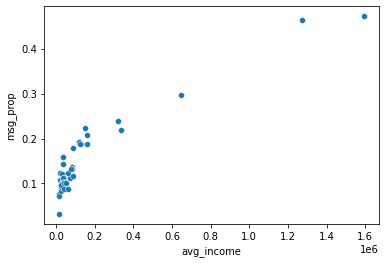

In [29]:
msg_dat_summ_df = dat_df.groupby('zip').agg(
    {'income' : [lambda x: sum(x.isnull())/np.size(x), np.mean]})
msg_dat_summ_df.columns = ['msg_prop', 'avg_income']
sns.scatterplot(data=msg_dat_summ_df, x="avg_income", y="msg_prop")

There appears to be a strong relationship between the two variables. This makes it highly unlikely that income is MCAR. It may be MAR on zip code, or zip code is correlated with income and income is MNAR. We can't distinguish between these two hypotheses based on the data available, but the latter one (MNAR) is the most likely from a behavioral standpoint. 

# 2. Correcting for the missingness

2. a. Run a logistic regression of bkd_mm on income, imputing the missing values with MICE. What is the coefficient for income?

In [38]:
#MICE imputation
MI_data_df = mice.MICEData(dat_df)     
fit =  mice.MICE(model_formula='bkd_mm~income', 
                model_class=sm.Logit, data=MI_data_df)          
MI_fit = fit.fit(n_imputations=20)

Optimization terminated successfully.
         Current function value: 0.080538
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.082102
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.075360
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.073272
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.078799
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.080687
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.080741
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.076614
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.078777
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.076561
  

In [39]:
MI_fit.params

array([-5.51168895e+00,  1.13848253e-05])

The coefficient for imputing the missing values with MICE is approx. 4.1*1e-7, pretty close to the coefficient obtained after replacing the missing values by the maximum income. 